In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import cdlib
import networkx as nx
import random

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'wurlitzer', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
dists, dat, keys = load(quick_return=True)

In [3]:
## Dists for Linkage Calculation
dists = dists.groupby(dat[['topic_id','member-ref']].astype(str).agg('_'.join,axis=1)).mean()
topic_sesst = dict(zip(dat.topic_id,dat.sess_type))
topic_dates = dict(zip(dat.topic_id,dat.date))
topic_dates = {topic:pd.Timestamp(year = _.year, month = 1 if _.month < 7 else 6, day = 1) for topic,_ in topic_dates.items()}

dists = dists[dists.index.str.split('_').str[0].map(topic_sesst) == 'plenary']

dists = dists[[v for v in dists.columns if 'rhet' not in keys[int(v)] and 'nonse' not in keys[int(v)] and 'proc' not in keys[int(v)]]]
dists = dists.div(dists.sum(axis=1), axis=0)

# Select TOPIC-MEMBER pairs based on above-average topic use
tm_dates = {i:(topic_dates[i.split('_')[0]],i.split('_')[1]) for i in dists.index}
mb_per_top = dists.groupby(dists.index.map(tm_dates)).mean().apply(zscore,axis=0)
mb_per_top_d = mb_per_top.apply(lambda row: row[row > 0].index.tolist(), axis=1).to_dict()

# Filter Dist
dz = dists.apply(zscore,axis=0)
dists = dists.where(dz >= 0, 0.0000000000001)
dists = dists.div(dists.sum(axis=1), axis=0)

In [4]:
mb_per_top_d = {}

for date, _ in dists.groupby(dists.index.str.split('_').str[0].map(topic_dates)):
    p_topic = _.mean()
    for mb,dd in _.groupby(_.index.str.split('_').str[1]):
        dd = dd.mean()
        dd = zscore(dd / p_topic)
        dd = dd[dd > 1].index.astype(int).map(keys).tolist()
        mb_per_top_d[(date,mb)] = dd

In [5]:
dists.index = dists.index.str.split('_').str[0].map(topic_dates)

networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

In [6]:
def connect_mb(dists, networks, tc):
    network_periods = list(sorted(networks.keys()))
    dat_long = []
    for period in tqdm(sorted(dists.index.unique())):
        mbd = {mb:tops for (date,mb),tops in mb_per_top_d.items() if date == date}
        pix = network_periods.index(period)
        cm_mbd = {comm:[(mb,overlap_coefficient(set(tps),set(tops))) for mb,tops in mbd.items()] for comm,tps in enumerate(tc.get_clustering_at(pix).communities)}
        if len(cm_mbd.items()) > 1:
            
            for clusn, members in cm_mbd.items():
                tc_format = f"{pix}_{clusn}"
                for m,ov in members:
                    dat_long.append({"period":period,"clusn":clusn,"mb":m,"ov":ov,"cid":tc_format,"clus_size":len(tc.get_community(tc_format))})
    return pd.DataFrame(dat_long)

In [7]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.45, louvain_res=2.5,min_chain_len=4,verbose=False)
dl = connect_mb(dists, networks, tc)

100%|██████████| 95/95 [00:04<00:00, 21.17it/s]


# Path Matching

Match paths to members, calculate specialist overlap with previous periods within every path (with bootstrapping).

In [8]:
r = []
for _ in range(10):
    tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.45, louvain_res=3,min_chain_len=4,verbose=False)
    dl = connect_mb(dists, networks, tc)
    dld = dl[dl.ov > .35].groupby('cid').apply(lambda g:g.mb.tolist()).to_dict()
    path_mbs = [[dld.get(x) for x in p] for p in paths]
    results = [
        {
            "path_id": cc,
            "path_ix": c,
            "path_start": int(paths[cc][0].split('_')[0]),
            "overlap": overlap_coefficient(set(e), set(p[c-1]))
        }
        for cc, p in enumerate(path_mbs)
        for c, e in enumerate(p) if c != 0
    ]
    results = pd.DataFrame(results)
    results['iter'] = _
    r.append(results)

100%|██████████| 95/95 [00:04<00:00, 21.17it/s]


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

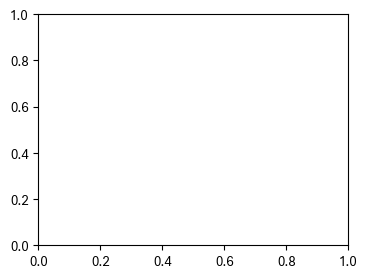

In [16]:
## Plot
f,a = plt.subplots(1,1,figsize=(4,3))

r = pd.concat(r)

sns.lineplot(data=r,x='path_ix',y='overlap',ax=a,color='black')

a.set_xlim(1,15)
# a.set_ylim(.4,.9)

# a.set_title(''.upper(),fontweight='bold',fontsize=15)
a.set_xlabel('Path Index'.upper(),labelpad=10,fontsize=15)
a.set_ylabel('Overlap Ratio'.upper(),labelpad=10,fontsize=15)
plt.savefig('figs/path-mb-overlap.png',dpi=400,bbox_inches='tight')
plt.show()

In [10]:
def chain2topic(tc,chain,s=4):
    topics = []
    for cluster in chain:
        topics += tc.get_community(cluster)
    return ', '.join([f"{t} ({c})" for t,c in Counter(topics).most_common(s)])

In [11]:
rmd = []
for cix , (pmb,p) in enumerate(zip(path_mbs,paths)):
    ttrt = Counter([item for items in p for item in tc.get_community(items)])
    ttrt = [v for k,v in ttrt.items()]
    ttrt = [v / sum(ttrt) for v in ttrt]
    # ttrt = len(set(ttrt)) / len(ttrt)
    ttrm = Counter([item for items in pmb for item in items])
    ttrm = [v for k,v in ttrm.items()]
    ttrm = [v / sum(ttrm) for v in ttrm]
    # ttrm = len(set(ttrm)) / len(ttrm)
    rmd.append({"cix":cix,"ttrt":sum([v**2 for v in ttrt]),"ttrm":sum([v**2 for v in ttrm]),"size":len(p) * 5})

In [12]:
simp = []

for cc,pp in enumerate(paths):
    for ccc,ppp in enumerate(paths):
        if cc != ccc:
            s1 = set([item for items in pp for item in tc.get_community(items)])
            s2 = set([item for items in ppp for item in tc.get_community(items)])
            simp.append({"p1":cc,"p2":ccc,"o":jaccard_similarity(s1,s2)})
simp = pd.DataFrame(simp)
simp = simp[simp.o > .5]

In [13]:
rmd = pd.DataFrame(rmd)#.plot.scatter(x='ttrt',y='ttrm',ylabel='Dyn. Comm. Topic Entropy',xlabel='Dyn. Comm. Member Entropy')

In [23]:
import statsmodels.api as sm

def plot_confidence_interval(x, y, ax, color='blue', alpha=0.2):
    # Ensure numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Fit regression model
    X = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    # Get prediction intervals
    pred = model.get_prediction(X)
    pred_summary = pred.summary_frame(alpha=alpha)
    
    # Plot regression line
    ax.plot(x, predictions, color=color, linestyle='--')
    
    # Plot confidence interval band
    # ax.fill_between(x, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color=color, alpha=alpha, label='Confidence Interval')

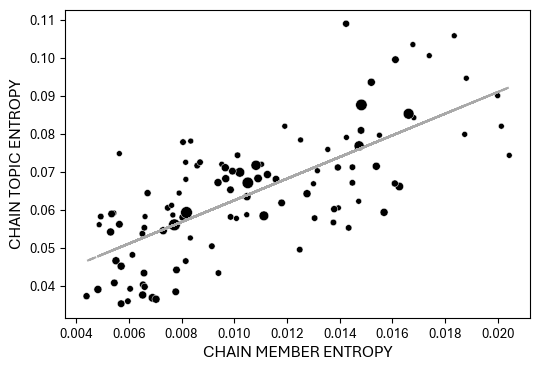

In [24]:
f,a=plt.subplots(figsize=(6,4))
sns.scatterplot(data=rmd,x='ttrm',y='ttrt',size='size',ax=a,legend=False,color='black',edgecolor='white')

plot_confidence_interval(rmd.ttrm,rmd.ttrt,ax=a,color='darkgrey')
# a.set_yscale('log')
# a.set_xscale('log')
a.set_ylabel('Chain Topic Entropy'.upper())
a.set_xlabel('Chain Member Entropy'.upper())
plt.savefig('figs/chain-tp-mb-entropy.png',dpi=400,bbox_inches='tight')
plt.show()